In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import xgboost as xgb

# 讀取資料
# normal_data_path = "src/df_normal.parquet"
anomalous_data_path = "df_anomalous.parquet"

df = pd.read_parquet(anomalous_data_path)

print(df.columns)
X = df.drop(columns=['Label'])  # 特
y = df['Label']  # 標籤

# 對 Label 進行編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [1]:
import pandas as pd

# 建立初始資料
data = {
    "指標": ["總利潤 (點)", "勝率", "獲利因子", "最大回撤"],
    "基準策略": [2415, 74.46, 7.46, -23.24],
    "ML 增強策略": [81361, 80.58, 311.29, -18.00]
}

df = pd.DataFrame(data)

# 計算改善幅度
def calc_improvement(base, enhanced, metric):
    # 對回撤取相反數計算正向改善
    if "回撤" in metric:
        return (base - enhanced) / abs(base) * 100
    else:
        return (enhanced - base) / abs(base) * 100

df["改善幅度"] = [f"{calc_improvement(b, e, m):.1f}%" for b, e, m in zip(df["基準策略"], df["ML 增強策略"], df["指標"])]

print(df)


        指標     基準策略   ML 增強策略     改善幅度
0  總利潤 (點)  2415.00  81361.00  3269.0%
1       勝率    74.46     80.58     8.2%
2     獲利因子     7.46    311.29  4072.8%
3     最大回撤   -23.24    -18.00   -22.5%


In [2]:
# 標準化數據
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 定義 k-fold 交叉驗證
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 設定 5 折交叉驗證
fold_no = 1
val_accuracies = []  # 用來儲存每一折的驗證準確度

for train_index, val_index in kf.split(X_train):
    print(f"\nTraining fold {fold_no}...")
    
    # 分割數據為訓練集和驗證集
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # 建立改進的 DNN 模型
    model = Sequential([
        Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_fold.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    # 編譯模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 回調函數列表
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    ]
    
    # 訓練模型
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=callbacks
    )

    # 評估每一折的驗證結果
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for fold {fold_no}: {val_accuracy * 100:.2f}%")
    
    fold_no += 1

# 計算平均準確度和標準差
avg_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)

print(f"\nAverage Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
print(f"Standard Deviation of Validation Accuracy: {std_val_accuracy * 100:.2f}%")


Training fold 1...
Epoch 1/50


/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7496/7496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9905 - loss: 0.1968 - val_accuracy: 0.9969 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 2/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9951 - loss: 0.0428 - val_accuracy: 0.9969 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 3/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9956 - loss: 0.0385 - val_accuracy: 0.9966 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 4/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9955 - loss: 0.0371 - val_accuracy: 0.9951 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 5/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9956 - loss: 0.0342 - val_accuracy: 0.9961 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 6/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9956 - loss: 0.0323 - val_accuracy: 0.9965 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 7/50
7496/7496 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9962 - loss: 0.02


Average Validation Accuracy: 99.74%


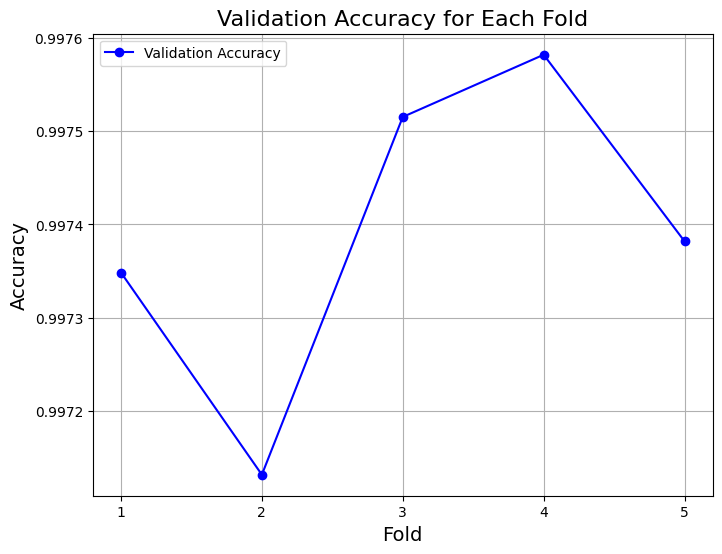

2343/2343 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.9975 - loss: 0.0120
Test Accuracy: 99.74%


In [3]:
# 計算 k-fold 交叉驗證的平均準確度
average_val_accuracy = np.mean(val_accuracies)
print(f"\nAverage Validation Accuracy: {average_val_accuracy * 100:.2f}%")

# 顯示 val_accuracies 圖表
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.title('Validation Accuracy for Each Fold', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(val_accuracies) + 1))
plt.grid(True)
plt.legend()
plt.show()

# 最後評估測試集的表現
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2343/2343 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step
Accuracy: 99.74%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19568
           1       1.00      1.00      1.00     55390

    accuracy                           1.00     74958
   macro avg       1.00      1.00      1.00     74958
weighted avg       1.00      1.00      1.00     74958



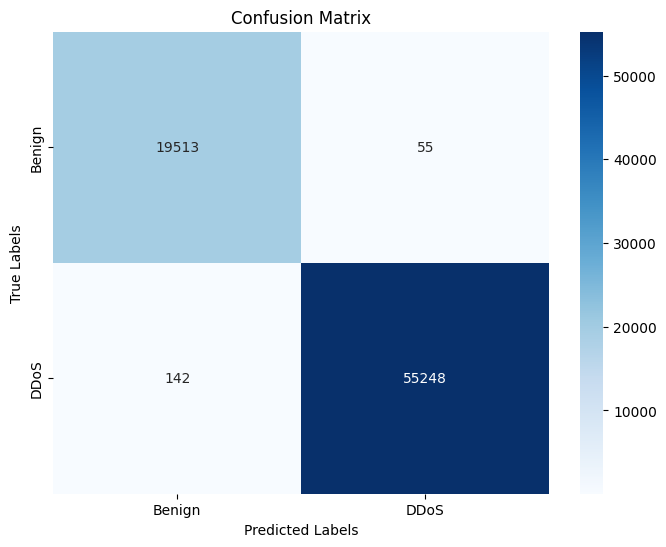

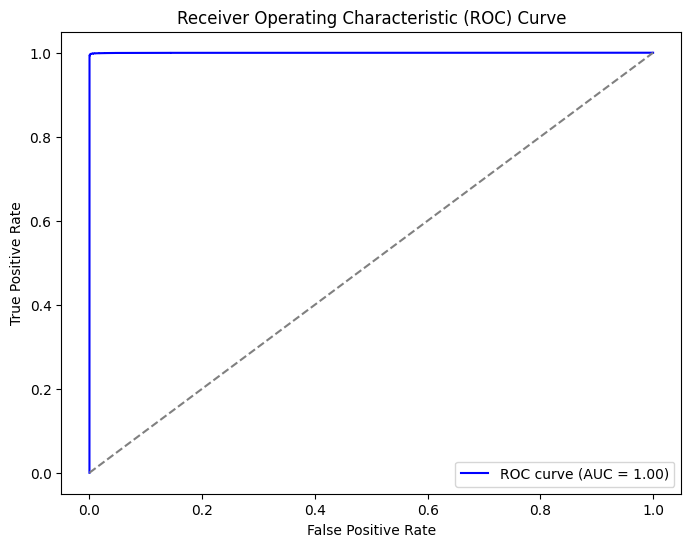

AUC: 1.00
Cross-Entropy Loss: 0.0099


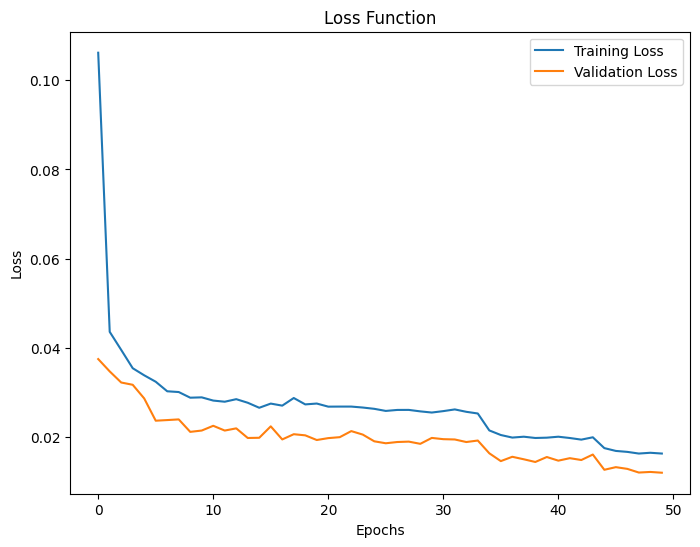

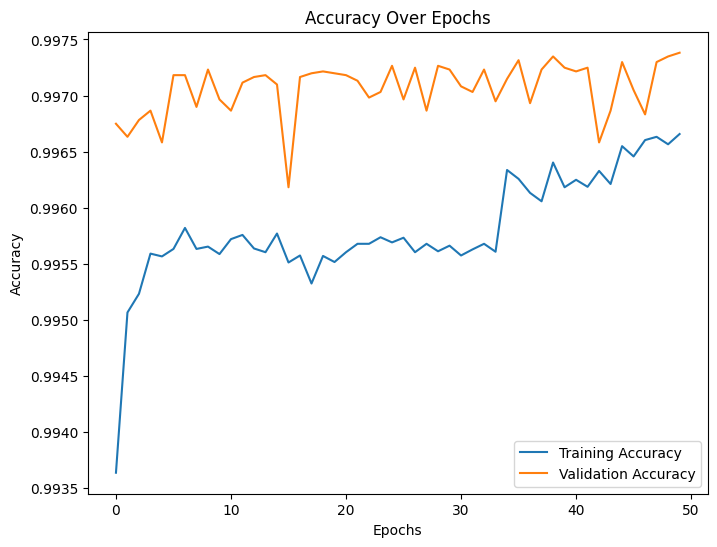

In [4]:

y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  # 

# 1. Accuracy
accuracy = np.mean(y_pred_classes == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# 2. Classification Report (F1-Score, Recall, Precision)
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 4. ROC Curve and AUC
# 计算 AUC，假设是二分类任务，选择第2列作为正类概率
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])  # 二分类时的正类概率（假设为 y_pred[:, 1]）
roc_auc = auc(fpr, tpr)

# 可视化 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 打印 AUC 值
print(f"AUC: {roc_auc:.2f}")

# 5. Loss Function (Cross-Entropy)
# 交叉熵损失计算
# 假设你使用的是二分类，且 y_pred 输出是概率值
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)  # 将标签转换为独热编码
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
loss_value = cross_entropy_loss(y_test_one_hot, y_pred).numpy()

print(f"Cross-Entropy Loss: {loss_value:.4f}")

# 如果是多分类任务，使用 CategoricalCrossentropy
# cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# loss_value = cross_entropy_loss(y_test_one_hot, y_pred).numpy()

# 6. Loss Function (Training/Validation Loss)
# 如果你已经训练了模型，可以获取训练的损失
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

# 可视化损失函数
plt.figure(figsize=(8, 6))
plt.plot(history_loss, label='Training Loss')
plt.plot(history_val_loss, label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# 假设你已经获得了训练历史
history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']

# 可视化 Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_accuracy, label='Training Accuracy')
plt.plot(history_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 使用 SHAP 的 DeepExplainer
explainer = shap.DeepExplainer(model, X_train[:100])  # 使用部分訓練集作為背景數據
shap_values = explainer.shap_values(X_test[:100])  # 分析部分測試數據

# 確認 SHAP 值的結構
print(f"SHAP Values Type: {type(shap_values)}")
for i, sv in enumerate(shap_values):
    print(f"Class {i} SHAP Values Shape: {sv.shape}")

# 全局特徵重要性分析
# 因為是多類分類，shap_values 是一個列表，每個類別都有一組 SHAP 值
for i, sv in enumerate(shap_values):
    print(f"Visualizing SHAP summary for Class {i}")
    shap.summary_plot(shap_values[0], X_test[:100], feature_names=df.drop(columns=['Label']).columns)
# 單個數據點的局部解釋
idx = 0  # 測試集中第 0 個數據點
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][idx],
    X_test[idx],
    feature_names=df.drop(columns=['Label']).columns
)

In [6]:
from lime import lime_tabular

# 初始化LIME解釋器
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,  # 必須是numpy.ndarray
    feature_names=X.columns.tolist(),
    class_names=label_encoder.classes_,  # 類別名稱
    mode='classification'
)

# 單個數據點解釋
idx = 0  # 測試集中的第一個數據點
exp = explainer.explain_instance(
    data_row=X_test[idx],  # 測試集中的一個數據點
    predict_fn=lambda x: model.predict(x),  # 確保返回每個類別的概率
)

# 可視化解釋
exp.show_in_notebook(show_table=True)

# 如果想保存結果到HTML
exp.save_to_file("lime_explanation.html")

InvalidIndexError: (slice(None, None, None), 0)

# 比較


In [50]:
# Directory path
import os


base_path = '/Users/hungwei/Downloads/cicddos2019/versions/3/'

# List of training file paths
file_paths = [
    os.path.join(base_path, 'LDAP-training.parquet'),
    os.path.join(base_path, 'MSSQL-training.parquet'),
    os.path.join(base_path, 'NetBIOS-training.parquet'),
    os.path.join(base_path, 'Portmap-training.parquet'),
    os.path.join(base_path, 'Syn-training.parquet'),
    os.path.join(base_path, 'UDP-training.parquet'),
    os.path.join(base_path, 'UDPLag-training.parquet')
]

# Read and concatenate all Parquet training files into a single DataFrame
dfs = [pd.read_parquet(file_path) for file_path in file_paths]
df_combined = pd.concat(dfs, ignore_index=True)

df_original = df_combined

# Strip column names
df_combined.columns = df_combined.columns.str.strip()

# Replace "Benign" with "DDoS" in the "Label" column (if the column exists)
# Replace all values in the "Label" column with "DDoS", except "Benign"
if 'Label' in df_combined.columns:
    df_combined['Label'] = df_combined['Label'].apply(lambda x: 'DDoS' if x != 'Benign' else x)


# Add each column index and name as a row in the table

print(df_combined)

X = df_combined.drop(columns=['Label'])  # 特徵
y = df_combined['Label']  # 標籤

# 對 Label 進行編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 分割資料集
X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


        Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             17             49                  2                       0   
1             17              1                  2                       0   
2             17              1                  2                       0   
3             17              1                  2                       0   
4             17              1                  2                       0   
...          ...            ...                ...                     ...   
125165         6             53                  1                       2   
125166         6             66                  1                       2   
125167        17          26288                  2                       2   
125168         6          30679                  1                       1   
125169         6             67                  1                       2   

        Fwd Packets Length Total  Bwd Packets Length Total  \
0

In [51]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 建立改進的 DNN 模型
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_fold.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(len(np.unique(y_train)), activation='softmax')
])

# 編譯模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 回調函數列表
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# 訓練模型
history = model.fit(
    X_train_fold, y_train_fold,
    validation_data=(X_val_fold, y_val_fold),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)



Epoch 1/50


/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3130/3130 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8346 - loss: 0.5744 - val_accuracy: 0.7474 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 2/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8946 - loss: 0.3196 - val_accuracy: 0.7521 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 3/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8975 - loss: 0.3021 - val_accuracy: 0.7416 - val_loss: 0.7786 - learning_rate: 0.0010
Epoch 4/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9033 - loss: 0.2882 - val_accuracy: 0.7512 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 5/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8982 - loss: 0.2939 - val_accuracy: 0.7495 - val_loss: 0.6429 - learning_rate: 0.0010
Epoch 6/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9018 - loss: 0.2911 - val_accuracy: 0.7515 - val_loss: 0.8106 - learning_rate: 0.0010
Epoch 7/50
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9002 - loss: 0.2893

783/783 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.7551 - loss: 0.4120
Validation Accuracy: 75.21%
783/783 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


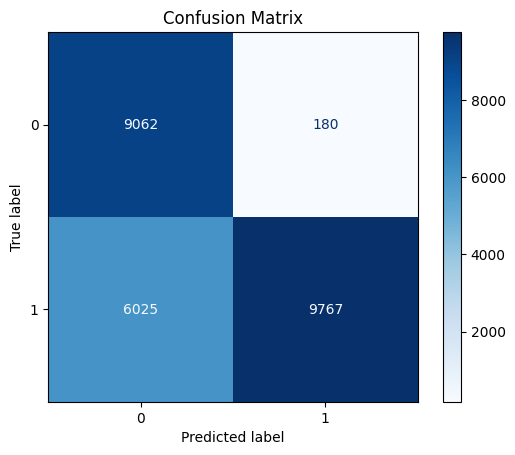

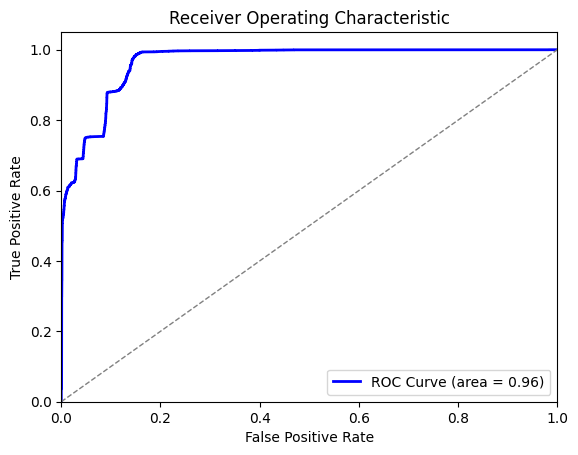

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 評估模型
val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# 預測結果
y_val_pred_prob = model.predict(X_val_fold)
y_val_pred = y_val_pred_prob.argmax(axis=1)

# 混淆矩陣
conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_train))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC 曲線與 AUC
if len(np.unique(y_train)) == 2:  # 二分類
    fpr, tpr, _ = roc_curve(y_val_fold, y_val_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:  # 多分類
    y_val_fold_binarized = label_binarize(y_val_fold, classes=np.unique(y_train))
    n_classes = y_val_fold_binarized.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_fold_binarized[:, i], y_val_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 微平均 ROC 曲線
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_fold_binarized.ravel(), y_val_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label=f"Micro-average ROC (area = {roc_auc['micro']:.2f})")
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Micro-average)')
    plt.legend(loc="lower right")
    plt.show()